In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [210]:
def show_anomaly_graph(data_source, title):
  plt.figure(figsize=(15,6))
  plt.plot(data_source['Czas'], data_source['Temperatura procesora'], label='Temperatura')
  plt.scatter(data_source['Czas'][data_source['Anomalia'] == 1], data_source['Temperatura procesora'][data_source['Anomalia'] == 1], color='red', label='Anomalia')
  plt.xlabel("Czas")
  plt.ylabel("Temperatura")
  plt.title(title)
  plt.legend()
  plt.show()

In [211]:
data = pd.read_csv('./data/CPUTemperatureLog.csv')
data['Czas'] = pd.to_datetime(data['Czas'])

In [212]:
data.head()

,Czas,Temperatura procesora
0,2024-08-06 12:51:30,47
1,2024-08-06 12:51:31,49
2,2024-08-06 12:51:32,48
3,2024-08-06 12:51:33,47
4,2024-08-06 12:51:34,46


In [213]:
data.shape

(1272, 2)

In [214]:
data.describe()

,Czas,Temperatura procesora
count,1272,1272.000000
mean,2024-08-06 13:02:05.500000,42.721698
min,2024-08-06 12:51:30,40.000000
25%,2024-08-06 12:56:47.750000128,41.000000
50%,2024-08-06 13:02:05.500000,42.000000
75%,2024-08-06 13:07:23.249999872,44.000000
max,2024-08-06 13:12:41,56.000000
std,NaN,2.577437


Każda kolumna posiada taką samą ilość danych, co oznacza, że nie posiadamy żadnych brakujących informacji a naszym zbiorze

Text(0.5, 1.0, 'Seria danych')

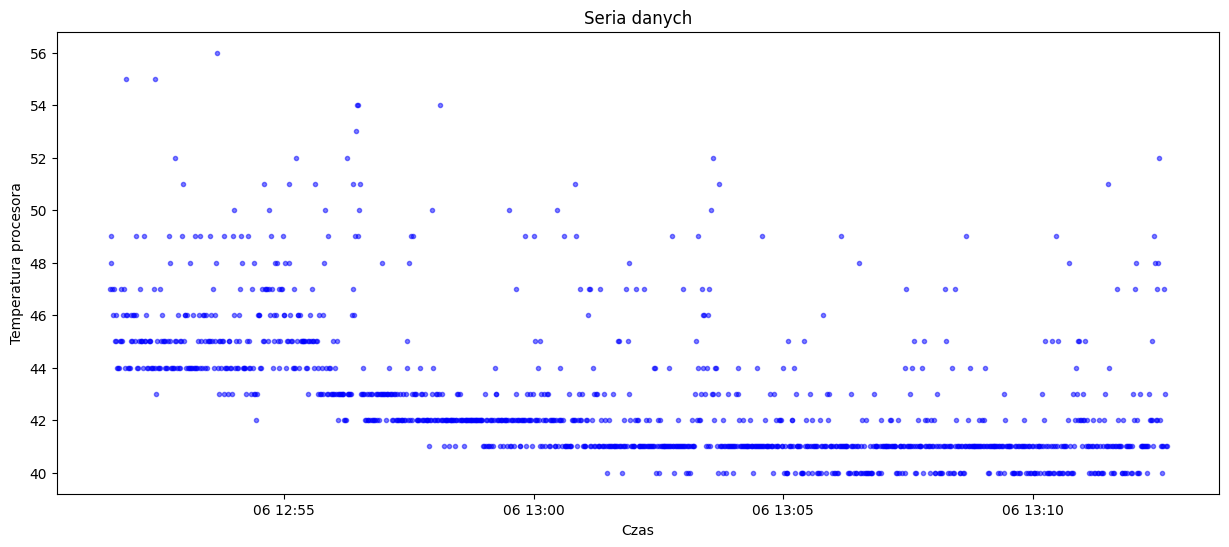

In [215]:
plt.figure(figsize=(15, 6))
plt.plot(data['Czas'], data['Temperatura procesora'], 'b.', alpha=0.5)
plt.xlabel("Czas")
plt.ylabel("Temperatura procesora")
plt.title("Seria danych")

# Las izolacyjny

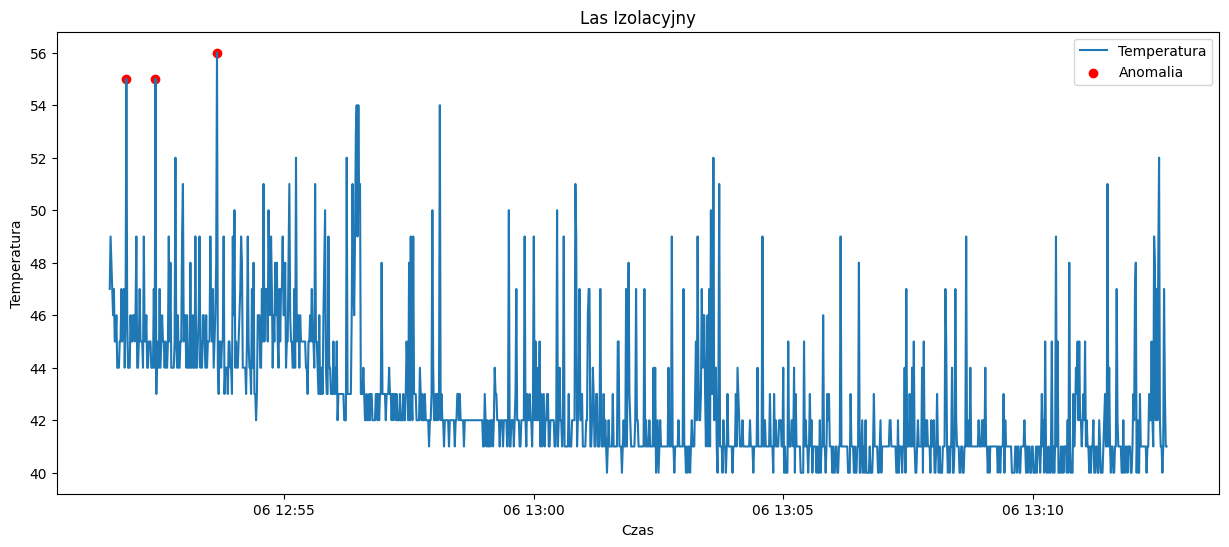

In [221]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

data_isolation_forest = data.copy()

outliers_fraction = float(.003)

scaler = StandardScaler()
np_scaled = scaler.fit_transform(data_isolation_forest[["Temperatura procesora"]])
data_temperature_std = pd.DataFrame(np_scaled, columns=data_isolation_forest[["Temperatura procesora"]].columns)

model = IsolationForest(contamination=outliers_fraction)
model.fit(data_temperature_std)

data_isolation_forest['Anomalia'] = model.predict(data_temperature_std)
data_isolation_forest['Anomalia'] = data_isolation_forest['Anomalia'].apply(lambda x: 1 if x == -1 else 0)

show_anomaly_graph(data_isolation_forest, title='Las Izolacyjny')

# HBOS

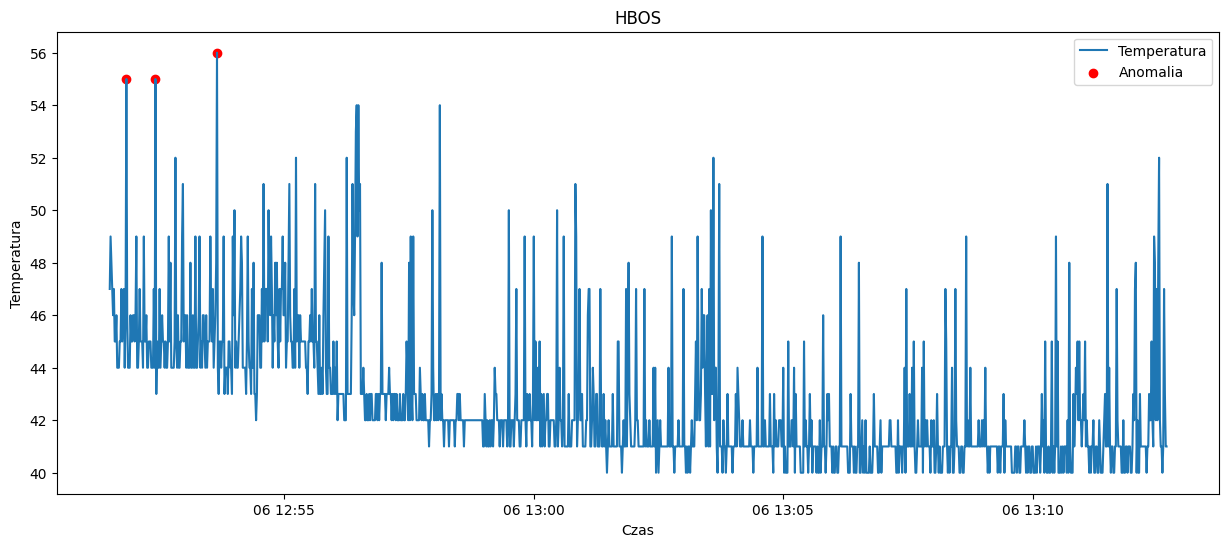

In [217]:
from pyod.models.hbos import HBOS

data_hbos = data.copy()

model = HBOS(contamination=0.003)

model.fit(data_hbos[["Temperatura procesora"]])
data_hbos["Anomalia"] = model.predict(data_hbos[["Temperatura procesora"]])

show_anomaly_graph(data_hbos, title='HBOS')

# K-means

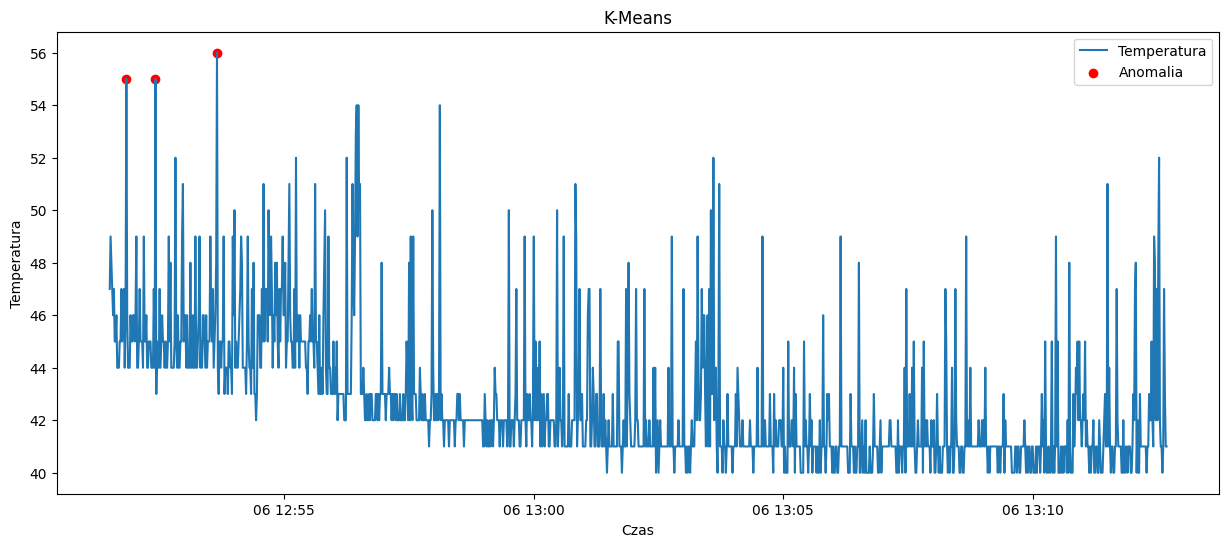

In [218]:
from sklearn.cluster import KMeans

data_k_means = data.copy()

kmeans = KMeans(n_clusters=3)
data_k_means['Klaster'] = kmeans.fit_predict(data_k_means[['Temperatura procesora']])

data_k_means['Odlegosc'] = np.linalg.norm(data_k_means[['Temperatura procesora']] - kmeans.cluster_centers_[data_k_means['Klaster']], axis=1)

threshold = np.percentile(data_k_means['Odlegosc'], 99.7)
data_k_means['Anomalia'] = (data_k_means['Odlegosc'] > threshold).astype(int)

show_anomaly_graph(data_k_means, title="K-Means")